# Clustering Crypto

In [51]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [52]:
# Use the following endpoint to fetch json data
import json
import pprint
url = "https://min-api.cryptocompare.com/data/all/coinlist"
r = requests.get(url)
content = r.content
content_d = content.decode('utf-8')
data = json.loads(content_d)

In [53]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
# dataframe creation
crypto_df = pd.DataFrame(data=data['Data'])

# Transpose Dataframe
crypto_df = crypto_df.T

crypto_df.head()

,Algorithm,BlockNumber,BlockReward,BlockTime,BuiltOn,CoinName,ContentCreatedOn,DecimalPlaces,FullName,FullyPremined,...,Rating,SmartContractAddress,SortOrder,Sponsored,Symbol,Taxonomy,TotalCoinSupply,TotalCoinsFreeFloat,TotalCoinsMined,Url
42,Scrypt,195131,0,0,N/A,42 Coin,1427211129,0,42 Coin (42),0,...,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",N/A,34,False,42,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",42,N/A,42,/coins/42/overview
300,N/A,0,0,0,7605,300 token,1517935016,18,300 token (300),0,...,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",0xaec98a708810414878c3bcdf46aad31ded4a4557,2212,False,300,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",300,N/A,300,/coins/300/overview
365,X11,NaN,NaN,NaN,N/A,365Coin,1480032918,0,365Coin (365),0,...,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",N/A,916,False,365,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",2300000000,N/A,NaN,/coins/365/overview
404,Scrypt,44853,72.0302,60,N/A,404Coin,1466100361,0,404Coin (404),0,...,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",N/A,602,False,404,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",532000000,N/A,1.1994e+06,/coins/404/overview
433,N/A,10821077,2,0,7605,433 Token,1541597321,18,433 Token (433),0,...,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",0x738505a5f31bf72e0b70298bca81150eb1b7c751,3505,False,433,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",1000000000,N/A,1.12517e+08,/coins/433/overview


In [54]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame

### Data Preprocessing

In [55]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df.drop(columns = ['BlockNumber', 'BlockReward', 'BlockTime', 'BuiltOn',
                          'ContentCreatedOn', 'DecimalPlaces', 'FullName',
                          'FullyPremined', 'Id', 'ImageUrl', 'Name',
                          'NetHashesPerSecond', 'PreMinedValue', 'Rating',
                          'SmartContractAddress', 'SortOrder', 'Sponsored', 'Symbol', 'Taxonomy',
                          'TotalCoinsFreeFloat', 'Url'], inplace=True)

# Reorder Columns that are still in the dataframe
crypto_df = crypto_df[['CoinName', 'Algorithm', 'IsTrading', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply']]

crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,42,42
300,300 token,N/A,True,N/A,300,300
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.1994e+06,532000000
433,433 Token,N/A,False,N/A,1.12517e+08,1000000000


In [56]:
# Keep only cryptocurrencies that are trading

# determine the count of false values(1094)
# crypto_df['IsTrading'].value_counts() 

crypto_df.drop(crypto_df[crypto_df['IsTrading'] == False].index,
              inplace=True)

In [57]:
# Keep only cryptocurrencies with a working algorithm
crypto_df.drop(crypto_df[crypto_df['Algorithm'] == 'N/A'].index, inplace=True)

In [58]:
# Remove the "IsTrading" column
crypto_df.drop(columns = ['IsTrading'], inplace=True)

In [59]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [60]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df.drop(crypto_df[crypto_df['TotalCoinsMined'] == 0].index, inplace=True)

In [61]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df != 'N/A'].dropna()

In [62]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
CoinName_df = crypto_df['CoinName'].to_frame()

In [63]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns = ['CoinName'], inplace=True)

In [64]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'], drop_first=True)

In [65]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [66]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X_scaled)

In [69]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(data=crypto_pca,
                            columns=['PC 1', 'PC 2', 'PC 3'],
                            index=crypto_df.index
                            )
pca_df.head()

,PC 1,PC 2,PC 3
42,-0.352753,0.753911,-0.388786
404,-0.348866,0.753763,-0.388837
1337,2.342678,1.445835,-0.477154
BTCD,-0.341285,0.738660,-0.252875
XPY,-0.299597,0.447210,-0.029130


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [71]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=6)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.hvplot.line(x='k', y='inertia',
                     title='Elbow Curve',
                     xticks=k)

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [82]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)
pca_df['class'] = model.labels_

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, CoinName_df, pca_df], axis=1)
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,CoinName,PC 1,PC 2,PC 3,class
42,Scrypt,PoW/PoS,42,42,42 Coin,-0.352753,0.753911,-0.388786,0
404,Scrypt,PoW/PoS,1.1994e+06,532000000,404Coin,-0.348866,0.753763,-0.388837,0
1337,X13,PoW/PoS,2.94803e+10,314159265359,EliteCoin,2.342678,1.445835,-0.477154,0
BTCD,SHA-256,PoW/PoS,1288862,22000000,BitcoinDark,-0.341285,0.738660,-0.252875,0
XPY,SHA-256,PoS,1.19953e+07,12500000,PayCoin,-0.299597,0.447210,-0.029130,0


### Visualizing Results

#### 3D-Scatter with Clusters

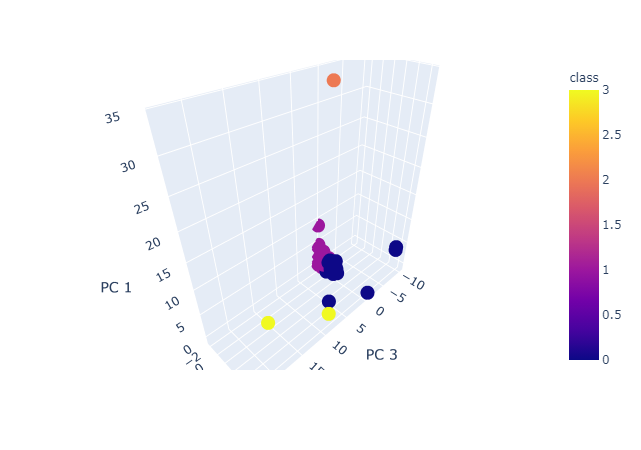

In [101]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_df,
                   x='PC 3',
                   y='PC 2',
                   z='PC 1',
                    color='class',
                   hover_name='CoinName',
                   hover_data=['Algorithm'],
                   width=800)
fig.show()

#### Table of Tradable Cryptocurrencies

In [91]:
# Table with tradable cryptos
clustered_df.hvplot.table(columns=['CoinName', 'Algorithm', 'ProofType',
                                  'TotalCoinSupply', 'TotalCoinsMined',
                                  'class']
                         )

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,class]

In [100]:
# Print the total number of tradable cryptocurrencies
print(f'The total number of tradable cryptocurrenices is: {len(clustered_df)}')

The total number of tradable cryptocurrenices is: 541


#### Scatter Plot with Tradable Cryptocurrencies

In [103]:
# Scale data to create the scatter plot


In [ ]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
.hvplot.scatter(
    x='TotalCoinsMined',
    y='TotalCoinSupply',
    hover_cols=["CoinName"],
)